# Random forest classification

## RAPIDS single GPU

<img src="https://rapids.ai/assets/images/RAPIDS-logo-purple.svg" width="400">

In [80]:
import os

# Load data and feature engineering

Load a full month for this exercise. Note we are loading the data with RAPIDS now (`cudf.read_csv` vs. `pd.read_csv`)

In [81]:
!nvidia-smi

Sat Dec 19 06:03:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    26W /  70W |   3140MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [82]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [83]:
import cudf
import s3fs
import xgboost as xgb

s3 = s3fs.S3FileSystem(anon=True)

data = cudf.read_csv(
    s3.open( 's3://kjkasjdk2934872398ojljosudfsu8fuj23/data_rev8.csv', mode='rb')
)

In [84]:
print(f'Num rows: {len(data)}, Size: {data.memory_usage(deep=True).sum() / 1e6} MB')

Num rows: 200000, Size: 305.688903 MB


In [85]:
data.shape

(200000, 189)

In [86]:
data = data.drop(columns=['Unnamed: 0', 'Time'])
data = data.astype('float32')

In [87]:
features = list(data.columns[1:])
target = data.columns[0]

In [116]:
len(features)

186

# Train model

In [88]:
%pip install pyDOE

Note: you may need to restart the kernel to use updated packages.


In [255]:
name = 10

n_samples = 20
tree_depth = [3,3]
sample_size = [0.676590, 0.676590]
mtry = [88, 88]
learn_rate = [0.001, 0.1]
trees = 1000
stop_iter = 20

In [256]:
from pyDOE import lhs
import numpy as np
np.random.seed(42)

lhd = lhs(4, samples=n_samples)

In [257]:
import pandas as pd

def scale_param(x, limits):
    range_ = limits[1]-limits[0]
    res = x*range_+min(limits)
    return res

samples = pd.DataFrame({
    'tree_depth': np.round(scale_param(lhd[:,0], tree_depth),0).astype(int).tolist(),
    'sample_size': scale_param(lhd[:,1], sample_size).tolist(),
    'mtry': np.round(scale_param(lhd[:,2], mtry),0).astype(int).tolist(),
    'learn_rate': scale_param(lhd[:,3], learn_rate).tolist()
    })
samples.head()

,tree_depth,sample_size,mtry,learn_rate
0,3,0.67659,88,0.022242
1,3,0.67659,88,0.047729
2,3,0.67659,88,0.010238
3,3,0.67659,88,0.077016
4,3,0.67659,88,0.036494


In [258]:
from tqdm.auto import tqdm
from cuml.metrics.regression import mean_absolute_error, mean_squared_error, r2_score

In [259]:
fold_train = []
fold_test = []
fold_test_np = []

n_folds = 4
folds_cumul = True

if n_folds == 4 and not folds_cumul:
    for fold in tqdm(range(4), total=4):
        fold_train_start = fold*40000
        fold_train_end = (fold+1)*40000
        fold_test_end = (fold+1)*50000

        train_data_x = data[features].iloc[fold_train_start:fold_train_end]
        train_data_y = data[target].iloc[fold_train_start:fold_train_end]

        test_data_x = data[features].iloc[fold_train_end:fold_test_end]
        test_data_y = data[target].iloc[fold_train_end:fold_test_end]

        fold_train.append(xgb.DMatrix(train_data_x, label=train_data_y))
        fold_test.append(xgb.DMatrix(test_data_x, label=test_data_y))
        fold_test_np.append(test_data_y)
        
if n_folds == 4 and folds_cumul:
    for fold in tqdm(range(4), total=4):
        fold_train_start = 0
        fold_train_end = 180000+(fold)*3000
        fold_test_end = fold_train_end+2016

        train_data_x = data[features].iloc[fold_train_start:fold_train_end]
        train_data_y = data[target].iloc[fold_train_start:fold_train_end]

        test_data_x = data[features].iloc[fold_train_end:fold_test_end]
        test_data_y = data[target].iloc[fold_train_end:fold_test_end]

        fold_train.append(xgb.DMatrix(train_data_x, label=train_data_y))
        fold_test.append(xgb.DMatrix(test_data_x, label=test_data_y))
        fold_test_np.append(test_data_y)

In [260]:
res = []

for sample in tqdm(list(samples.index), total=samples.shape[0]):
    this_res = {}

    this_res['tree_depth'] = samples.loc[sample, 'tree_depth']
    this_res['sample_size'] = samples.loc[sample, 'sample_size']
    this_res['mtry'] = samples.loc[sample, 'mtry']
    this_res['learn_rate'] = samples.loc[sample, 'learn_rate']
    this_res['res'] = {'folds': []}
    for fold in tqdm(range(4), total=4, leave=False):
        this_fold = {}
    
        params = {
            'verbosity': 0,
            'tree_method': 'gpu_hist',
            'n_gpus': 1,
            'eval_metric': 'mae',
                'max_depth': samples.loc[sample, 'tree_depth'],
                'subsample': samples.loc[sample, 'sample_size'],
                'colsample_bytree': samples.loc[sample, 'mtry']/len(features),
                'eta': samples.loc[sample, 'learn_rate']
        }
    
        evallist = [(fold_train[fold], 'train'),(fold_test[fold], 'validation')]
        num_round = 1000
        
        model = xgb.train(params, fold_train[fold], num_round, evals=evallist, early_stopping_rounds=stop_iter, verbose_eval=False)

        preds = model.predict(fold_test[fold])
        orig = fold_test_np[fold]
        
        this_fold['mae'] = float(mean_absolute_error(orig, preds))
        this_fold['rmse'] = float(mean_squared_error(orig, preds, squared=False))
        this_fold['r2'] = r2_score(orig, preds)
        this_fold['best_iter'] = model.best_iteration
        this_res['res']['folds'].append(this_fold)
    this_res['res']['mae'] = np.mean([x['mae'] for x in this_res['res']['folds']])
    this_res['res']['rmse'] = np.mean([x['rmse'] for x in this_res['res']['folds']])
    this_res['res']['r2'] = np.mean([x['r2'] for x in this_res['res']['folds']])
    print("tree_depth:{} sample_size:{} mtry:{} learn_rate:{} mae:{}".format(
    this_res['tree_depth'],this_res['sample_size'],this_res['mtry'],this_res['learn_rate'],this_res['res']['mae']))
    res.append(this_res)

tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.02224158424398031 mae:441.66361236572266


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.04772875484401103 mae:441.30260467529297


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.01023757192158593 mae:462.97704315185547


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.07701592896713327 mae:439.7607650756836


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.0364940944122521 mae:438.7006149291992


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.027563491124303778 mae:439.3434143066406


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.0841708750547325 mae:445.70863342285156


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.015701053768201877 mae:440.1063461303711


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.0937085854818029 mae:443.08524322509766


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.0167578523237745 mae:439.3824157714844


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.06423690747563753 mae:442.9193572998047


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.08613364262359416 mae:437.32708740234375


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.044601566873176485 mae:437.3394012451172


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.07191038513727817 mae:440.0998306274414


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.0039633594967753314 mae:514.4419250488281


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.06991327746336444 mae:435.7637405395508


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.033245460470147384 mae:444.22240447998047


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.05500113599028998 mae:445.11375427246094


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.0956235518446494 mae:435.43924713134766


tree_depth:3 sample_size:0.67659 mtry:88 learn_rate:0.05802433670483017 mae:446.2521057128906



In [261]:
rdf = pd.DataFrame({'tree_depth': [r['tree_depth'] for r in res],
 'sample_size': [r['sample_size'] for r in res],
 'mtry': [r['mtry'] for r in res],
                    'learn_rate': [r['learn_rate'] for r in res],
 'mae': [r['res']['mae'] for r in res],
                    'rmse': [r['res']['rmse'] for r in res],
                   'r2': [r['res']['r2'] for r in res]})

In [262]:
rdf.sort_values('mae')

,tree_depth,sample_size,mtry,learn_rate,mae,rmse,r2
18,3,0.67659,88,0.095624,435.439247,542.410568,0.774539
15,3,0.67659,88,0.069913,435.763741,544.581924,0.774071
11,3,0.67659,88,0.086134,437.327087,548.161522,0.769257
12,3,0.67659,88,0.044602,437.339401,546.516083,0.772622
4,3,0.67659,88,0.036494,438.700615,550.042770,0.768856
5,3,0.67659,88,0.027563,439.343414,549.754379,0.769588
9,3,0.67659,88,0.016758,439.382416,550.493881,0.768382
3,3,0.67659,88,0.077016,439.760765,548.642090,0.771104
13,3,0.67659,88,0.071910,440.099831,549.166458,0.769850
7,3,0.67659,88,0.015701,440.106346,551.610931,0.767999


In [263]:
rdf.to_csv('xgb{}.csv'.format(name))

In [264]:
rdf.corr()

,tree_depth,sample_size,mtry,learn_rate,mae,rmse,r2
tree_depth,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample_size,NaN,1.000000e+00,NaN,2.445119e-17,1.353059e-15,0.000000,-1.409606e-15
mtry,NaN,NaN,NaN,NaN,NaN,NaN,NaN
learn_rate,NaN,2.445119e-17,NaN,1.000000e+00,-4.636637e-01,-0.486660,4.855678e-01
mae,NaN,1.353059e-15,NaN,-4.636637e-01,1.000000e+00,0.997625,-9.951073e-01
rmse,NaN,0.000000e+00,NaN,-4.866596e-01,9.976253e-01,1.000000,-9.955431e-01
r2,NaN,-1.409606e-15,NaN,4.855678e-01,-9.951073e-01,-0.995543,1.000000e+00


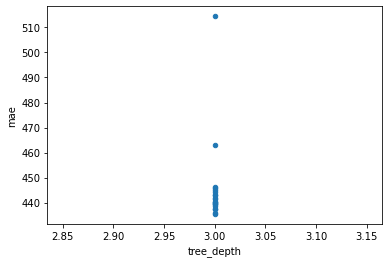

In [265]:
rdf.plot.scatter('tree_depth', 'mae');

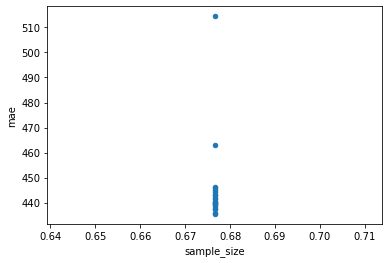

In [266]:
rdf.plot.scatter('sample_size', 'mae');

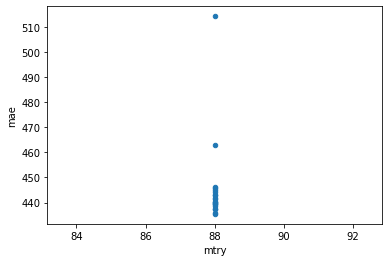

In [267]:
rdf.plot.scatter('mtry', 'mae');

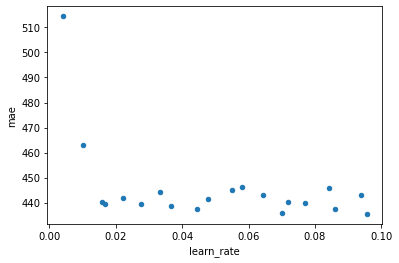

In [268]:
rdf.plot.scatter('learn_rate', 'mae');

In [269]:
rdf.sort_values('mae')

,tree_depth,sample_size,mtry,learn_rate,mae,rmse,r2
18,3,0.67659,88,0.095624,435.439247,542.410568,0.774539
15,3,0.67659,88,0.069913,435.763741,544.581924,0.774071
11,3,0.67659,88,0.086134,437.327087,548.161522,0.769257
12,3,0.67659,88,0.044602,437.339401,546.516083,0.772622
4,3,0.67659,88,0.036494,438.700615,550.042770,0.768856
5,3,0.67659,88,0.027563,439.343414,549.754379,0.769588
9,3,0.67659,88,0.016758,439.382416,550.493881,0.768382
3,3,0.67659,88,0.077016,439.760765,548.642090,0.771104
13,3,0.67659,88,0.071910,440.099831,549.166458,0.769850
7,3,0.67659,88,0.015701,440.106346,551.610931,0.767999
